In [44]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opitm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [45]:
torch.__version__

'1.10.2'

In [46]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [47]:
train_ds = torchvision.datasets.MNIST('dataset', train=True, transform=transform,
                                      download=True)

In [48]:
dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)

In [49]:
imgs, _ = next(iter(dataloader))
imgs.shape

torch.Size([64, 1, 28, 28])

数据集本身的大小是1通道，28x28；
所以需要生成的噪声转化成与输入相同的格式
而噪声本身长度是100
所以需要几步：
    100-256
    256-512
    521-28*28
    28*28-1,28,28

# 生成器

In [50]:
#定义生成器类
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            #对于生成器模型，最后使用Tanh激活，效果较好
            nn.Tanh()
        )

    def forward(self, x):
        img = self.main(x)
        img = img.view(-1, 28, 28, 1)
        return img

# 判别器：
输入是（1,28,28）的图片，输出是二分类的概率值，所以需要用sigmoid来激活
BCEloss来计算交叉熵损失

In [51]:
class Discrim(nn.Module):
    def __init__(self):
        super(Discrim,self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 512),
            #LeakyReLU会在负值保持一定梯度，而不是像relu时输出0
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            #输出是二分类的概率值，所以需要用sigmoid来激活
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.main(x)
        return x

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [53]:
gen = Generator().to(device)
dis = Discrim().to(device)
dis

Discrim(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

定义优化器：

In [54]:
#分别定义优化器
d_optim = opitm.Adam(dis.parameters(), lr= 0.0001)
g_optim = opitm.Adam(gen.parameters(), lr= 0.0001)

定义优化函数：

In [55]:
loss_fn = nn.BCELoss()

进行绘图

In [56]:
def gen_img_plot(model, test_input):
    predict = np.squeeze(model(test_input).detach().cpu().numpy())
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow((predict[i]+1) / 2)
        plt.axis('off')
    plt.show()

In [57]:
test_input = torch.randn(16, 100, device=device)

# GAN的训练：

In [60]:
D_loss = []
G_loss = []

当前是第0个epoch


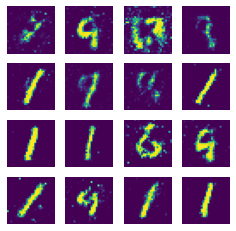

当前是第1个epoch


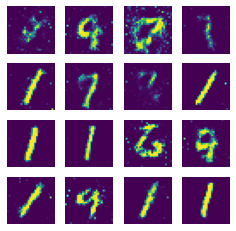

当前是第2个epoch


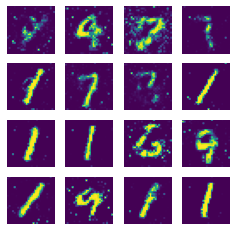

当前是第3个epoch


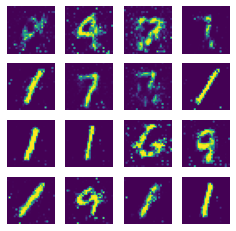

当前是第4个epoch


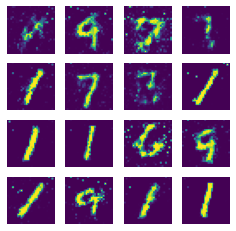

当前是第5个epoch


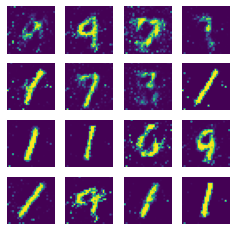

当前是第6个epoch


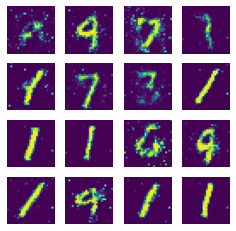

当前是第7个epoch


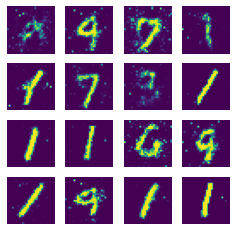

当前是第8个epoch


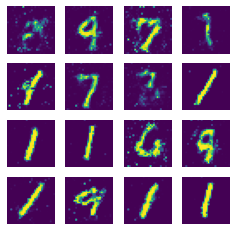

当前是第9个epoch


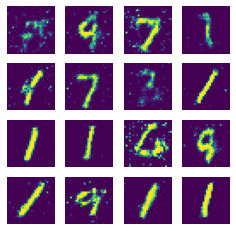

当前是第10个epoch


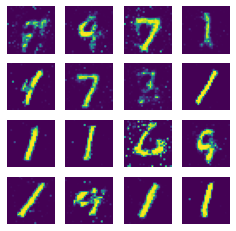

当前是第11个epoch


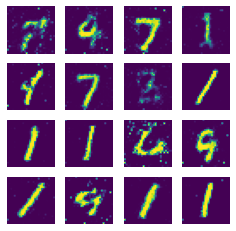

当前是第12个epoch


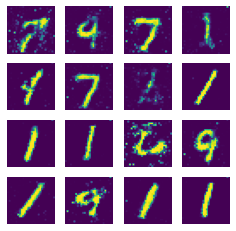

当前是第13个epoch


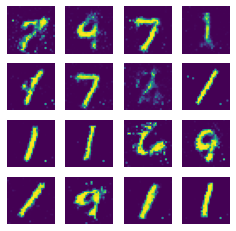

当前是第14个epoch


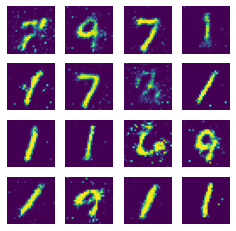

当前是第15个epoch


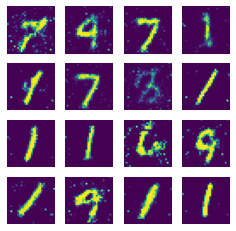

当前是第16个epoch


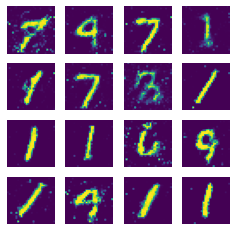

当前是第17个epoch


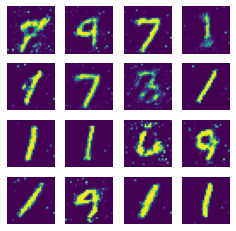

当前是第18个epoch


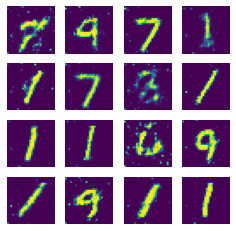

当前是第19个epoch


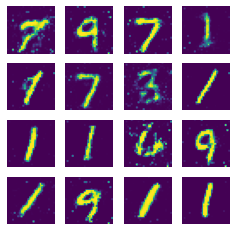

In [64]:
epochs = 20
for epoch in range(epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader) #批次数
    #迭代数据集：
    for step, (img,_) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)  #获取大小，以生成生成器的输入
        random_noise = torch.randn(size, 100, device=device)    #创建同样个数，长度为100的noise
        #整体判别器的损失计算+优化
        d_optim.zero_grad()
        #真实部分：
        real_output = dis(img)
        d_real_loss = loss_fn(real_output, torch.ones_like(real_output, device=device))   #真实结果与1的区别
        d_real_loss.backward()

        #把随机噪声放进生成器，进行生成；然后由判别器判断生成的图片
        gen_img = gen(random_noise)
        fake_out = dis(gen_img.detach())    #截断梯度，此处不对生成器进行优化
        d_fake_loss = loss_fn(fake_out, torch.zeros_like(fake_out, device=device))   #虚假结果与0的区别
        d_fake_loss.backward()

        d_loss = d_fake_loss + d_real_loss  #总的损失
        d_optim.step()  #判别器优化

        #生成器的损失计算+优化
        g_optim.zero_grad()
        fake_out2 = dis(gen_img) #仍然先获得输出，但是不进行梯度截断
        g_loss = loss_fn(fake_out2, torch.ones_like(fake_out2, device=device))  #判断与1的损失
        g_loss.backward()
        g_optim.step()  #生成器优化

        #统计输出相关
        with torch.no_grad():
            d_epoch_loss += d_loss
            g_epoch_loss += g_loss
    with torch.no_grad():
        d_epoch_loss /= count
        g_epoch_loss /= count
        #用列表保存平均loss
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print(f"当前是第{epoch}个epoch")
        gen_img_plot(gen, test_input)

torch.save(gen.state_dict(), f"gen.pth")
torch.save(dis.state_dict(), f"dis.pth")